"""
DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

© 2023 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.
"""

<div class="alert alert-block alert-info">
THIS NOTEBOOK IS ONLY SUPPORTED ON MacOS and Linux because pyscf does not have a Windows version.
Note, the DoubleFactorized block encoding implementation requires the python package openfermionpyscf to be installed. Additionally, the example in this notebook requires the python package pyscf.
</div>

<ul>
<li>WARNING!! You MUST run the optional install section in the <a href="..\..\..\README.md#optional-installs">README.md</li></a>
</ul>

In [ ]:
from pyLIQTR.ProblemInstances.getInstance  import *
from pyLIQTR.BlockEncodings.getEncoding    import *
from pyLIQTR.utils.resource_analysis       import estimate_resources
from pyLIQTR.utils.circuit_decomposition   import circuit_decompose_multi
from pyLIQTR.qubitization.phase_estimation import QubitizedPhaseEstimation
from pyLIQTR.qubitization.qubitized_gates  import QubitizedWalkOperator
from pyLIQTR.utils.printing                import openqasm

import numpy as np
from cirq.contrib.svg import SVGCircuit
from pyscf            import ao2mo, tools
from openfermion      import InteractionOperator
import cirq

In [3]:
def integrals2intop(h1, eri, ecore):
    norb = h1.shape[0]
    h2_so = np.zeros((2*norb, 2*norb, 2*norb, 2*norb))
    h1_so = np.zeros((2*norb, 2*norb))

    # Populate h1_so
    h1_so[:norb, :norb] = h1 
    h1_so[norb:, norb:] = h1_so[:norb, :norb]

    # Populate h2_so
    h2_so[0::2, 0::2, 0::2, 0::2] = eri 
    h2_so[1::2, 1::2, 0::2, 0::2] = eri
    h2_so[0::2, 0::2, 1::2, 1::2] = eri
    h2_so[1::2, 1::2, 1::2, 1::2] = eri

    # Transpose from 1122 to 1221 
    h2_so = np.transpose(h2_so, (1, 2, 3, 0))

    return InteractionOperator(constant=ecore, one_body_tensor=h1_so, two_body_tensor=h2_so)

References:\
    [1] [Even more efficient quantum computations of chemistry through tensor hypercontraction](https://arxiv.org/abs/2011.03494)\
    [2] [Quantum computing enhanced computational catalysis](https://arxiv.org/abs/2007.14460)

# Overview

This notebook walks through the steps for taking a catalyst as described by an fcidump file, generating a ProblemInstance, block encoding it using the DoubleFactorized algorithm, and estimating resources for the resulting qubitized phase estimation circuit. Printing the circuit to qasm is demonstrated at the end.

# Generate ProblemInstance

We can generate a pyLIQTR.ProblemInstance for a homogeneous catalyst whose info is stored in a fcidump file as follows.

In [4]:
filename='fcidump.2_co2_6-311'
mol_name = filename.split('_',1)[1]
fci_data = tools.fcidump.read(filename)
eri = ao2mo.restore('s1', fci_data['H2'], fci_data['NORB'])
hamiltonian_op = integrals2intop(h1 = fci_data['H1'], eri = eri, ecore=fci_data['ECORE'])
mol_instance = getInstance('ChemicalHamiltonian',mol_ham=hamiltonian_op,mol_name=mol_name)

Parsing fcidump.2_co2_6-311++G**


# Generate Double Factorized BlockEncoding

Next, we can generate a double factorized BlockEncoding for our ProblemInstance. The input parameters are as follows:

- `ProblemInstance`: A pyLIQTR.ProblemInstance for the system of interest. Currently supports ChemicalHamiltonian instances.
- `df_error_threshold`: The threshold used to throw out factors from the double factorization. Truncation is carried out as described in Appendix C Section 3 of Ref [1]. This parameter corresponds to the RHS of Eq C41.
- `sf_error_threshold`: The threshold used to throw out factors from the first eigendecomposition. Terms with eigenvalues less than or equal to sf_error_threshold are thrown out. This decreases L, the rank of the two body tensor in eq C10.
- `br`: The number of precision bits to use for the rotation angles output by the QROM in step 2 and used in step 3a)iv on page 52 of Ref [1]. Note, this is not used in step 1a which does not currently use a phase gradient rotation.
- `phase_gradient_eps`: Overall error in phase gradient state preparation, ie each rotation done to prepare the phase gradient state will be performed with error phase_gradient_eps/bits_rot_givens (see definition below).
- `energy_error`: The allowable error in phase estimation energy. Used to set bits_rot_givens, keep_bitsize, and outer_prep_eps if step_error is not passed as input.

Additional optional inputs:
- `step_error`: Error in spectral norm of walk operator. Corresponds to $\epsilon$ in Eq C24 of Ref [1]. Used to set bits_rot_givens, keep_bitsize, and outer_prep_eps if those are not passed as inputs.
    - Default: $0.1\frac{ \text{energy\_error} }{\alpha}$, where $\alpha$ is the double factorized Hamiltonian norm. Based on paragraph below Eq 1 of Ref [2].
- `bits_rot_givens`: Number of precision bits to use for the Givens rotations in step 4 on page 53 of Ref [1]. Called $\beth$ in Ref [1].
    - Default: ⎡5.625 + $\log_2\left(\frac{N}{2*\text{step\_error}}\right)$⎤, where $N$ is the number of spin orbitals. Based on Eq. C24.
- `keep_bitsize`: Number of precision bits to use for preparing the coefficients on the second selection register ($|p\rangle$). $\aleph_2$ in Eq C31 of Ref [1].
    - Default: ⎡2.5 + $\log_2\left(\frac{1}{\text{step\_error}}\right)$⎤, based on Eq C14.
- `outer_prep_eps`: Precision of normalized coefficients prepared on first selection register ($|\ell\rangle$). Used to set $\aleph_1$ in Eq C27 of Ref [1]. The two are related via $\aleph_1 = \max(0, ⎡-\log_2(\text{outer\_prep\_eps} * (L+1))⎤)$, where $L$ is the rank of the two body tensor.
    - Default: `step_error`

Note, if either energy_error or step_error are passed as input, the values of bits_rot_givens, keep_bitsize, and outer_prep_eps will default to numbers based on the input error. The user can also choose to pass values for some or all of these three parameters explicitly.

In [7]:
br = 7
df_error_threshold = 1e-3
sf_error_threshold = 1e-8
energy_error = 1e-3 

In [8]:
df_encoding = getEncoding(instance=mol_instance, encoding=VALID_ENCODINGS.DoubleFactorized,df_error_threshold=df_error_threshold,sf_error_threshold=sf_error_threshold,br=br,energy_error=energy_error)

We can access the block encoding circuit directly as follows.

In [ ]:
SVGCircuit(df_encoding.circuit)

To see more details of the block encoding circuit, we can decompose down one level.

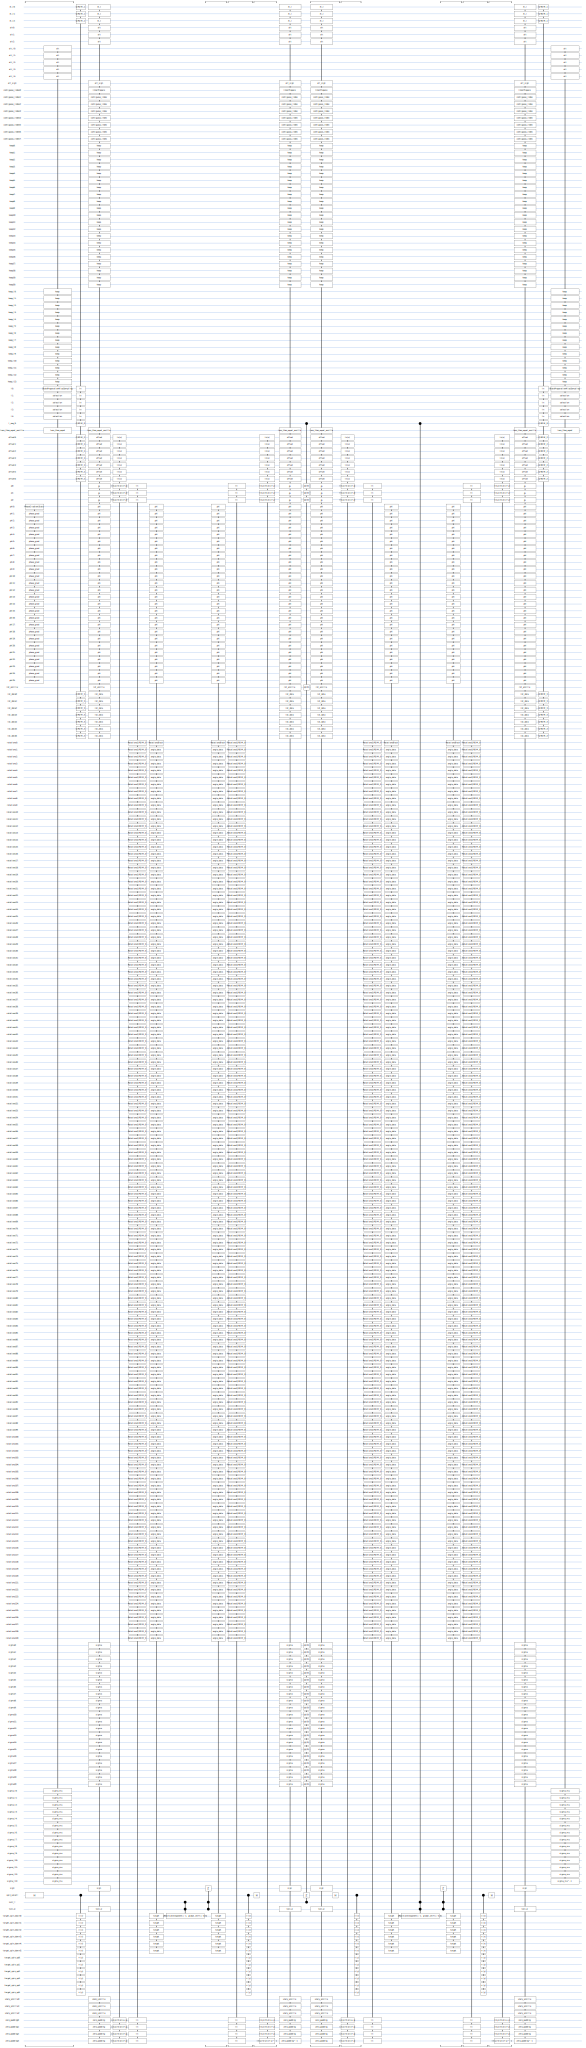

In [14]:
SVGCircuit(circuit_decompose_multi(df_encoding.circuit,1))

# Qubitized Phase Estimation

We can also use the encoding to generate a QubitizedWalkOperator or QubitizedPhaseEstimation directly for a given error target `eps`.

In [9]:
walk_op = QubitizedWalkOperator(df_encoding)

In [10]:
qpe = QubitizedPhaseEstimation(df_encoding,eps=1e-3)

Finally, we can estimate the resources of the walk operator in isolation or of the full phase estimation. Note that our estimate for T-count is done via an experimentally derived statistical distribution for the Clifford count of rotations at a given precision. This can be passed explicitly using the `rotation_gate_precision` (default 1e-10) keyword argument, or can be implicitly calculated by passing the `circuit_precision`. If no precision argument is provided, the default value will be used.

In [11]:
estimate_resources(walk_op)

{'LogicalQubits': 295, 'T': 19665, 'Clifford': 84254}

In [12]:
estimate_resources(qpe)

{'LogicalQubits': 305, 'T': 20137520, 'Clifford': 86277873}

---
#### LIQTR Like 👍 : Export of circuits to OpenQASM
---
Export of circuits can be done using a provided `pyLIQTR` utility (`pyLIQTR.utils.printing.openqasm`) that wraps `cirq`'s native openQASM export. This is introduced since some new qualtran operators do not yet have a decomposition in terms of gates defined, or `cirq` has begun to use features (mid-circuit measurement, classical control, etc) not supported by OpenQASM2.

This utility fully decomposes circuits to either include rotation gates (`rotation_allowed=True`) or not (`rotation_allowed=False`). 

In the latter case, we make use a of a Clifford+T representation outlined in https://arxiv.org/pdf/0806.3834.pdf (and further discussed in https://arxiv.org/pdf/1312.6584.pdf and http://www.cs.umd.edu/~amchilds/qa/qa.pdf, as potentially easier to digest forms).

When `rotation_allowed=False`, we introduce the "rx_d/ry_d/rz_d gate", followed by a line of the form:
```
// (leading_T, gate_sequence, sequence_length, clifford_part)
```
* `leading_T` : A bool indicating whether or not there is a `T` gate at the start of the sequence
* `gate_sequence`: An int whose binary representation encodes a sequence of `H`, `S`, and `T` gates
* `sequence_length`: The number of `T` gates in the sequence (note if `leading_T` is true, the total number of gates is `sequence_length+1`)
* `clifford_part`: A List[str] of clifford gates that come at the end of the H,S,T sequence.

Note that when `rotation_allowed=False`, you may also want to specify a level of precision by passing `gate_precision` or `circuit_precision` to `pyLIQTR.utils.printing.openqasm`. Also note that changing the qubit manager used for the decomposition context may result in errors.

In [13]:
context = cirq.DecompositionContext(cirq.SimpleQubitManager())
qasm = openqasm(df_encoding.circuit,context=context)
for ctr,line in enumerate(qasm):
    print(line)

// Generated from Cirq, Openfermion, and MIT LL

OPENQASM 2.0;
include "qelib1.inc";

// Qubits: [_c(0), _c(1), _c(2), _c(3), _c(4), _c(5), _c(6), _c(7), _c(8), _c(9), _c(10), _c(13), _c(14), _c(15), _c(16), _c(17), _c(18), _c(19), _c(20), _c(21), _c(22), _c(23), _c(24), _c(25), _c(26), _c(27), _c(28), _c(29), _c(30), _c(31), _c(32), _c(33), _c(34), _c(35), _c(36), _c(37), _c(38), _c(39), _c(40), _c(41), _c(42), _c(43), _c(44), _c(45), _c(46), _c(47), _c(48), _c(49), _c(50), _c(51), _c(52), _c(53), _c(54), _c(55), _c(56), _c(57), _c(58), _c(59), _c(60), _c(61), _c(62), _c(63), _c(64), _c(65), _c(66), _c(67), _c(68), _c(69), _c(70), _c(71), _c(72), _c(73), _c(74), _c(75), _c(76), _c(77), _c(78), _c(79), _c(80), _c(81), _c(82), _c(83), _c(84), _c(85), _c(86), _c(87), _c(88), _c(89), _c(90), _c(91), _c(92), _c(93), _c(94), _c(95), _c(96), _c(97), _c(98), _c(99), _c(100), _c(101), _c(102), _c(103), _c(104), _c(105), _c(106), _c(107), _c(108), _c(109), _c(110), _c(111), _c(112), _c(113), _c